In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator
import math
import itertools
import re
import statsmodels.api as sm
import os, glob
import datetime
from PIL import Image
import seaborn as sns

In [2]:
def growth_rate_to_weekly_perc(a):
    return 100*(math.exp(7*a)-1)

def N_avg(a, N=7):
    # hard edged convolution into past, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    for i in range(N-1):
        b[i] = np.nan
    for i in range(N-1,len(a),1):
        b[i] = np.mean(a[i-N+1:i+1])
    return b

In [3]:
def fit_inferred_exponential(y):
    _x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    _y = [y_val if (y_val and y_val>0) else np.nan for y_val in y]
    log_y = np.log(_y)
    _xsm = sm.add_constant(_x)
    results = sm.OLS(log_y,_xsm, missing="drop").fit()
    b,a = results.params
    r = results.rsquared
    return a,b # exp growth rate, "initial" value

def add_inferred_exponential(ax, y):
    x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    a,b = fit_inferred_exponential(y)
    y_pred = [math.exp(a*i+b) for i in x]    
    ax.plot(x, y_pred, color="blue", label="fitted to exponential growth")

In [4]:
def plot_rate(title, x, y, ylabel):
    # single plot with single inferred growth rate
    plt.clf()
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    fig.suptitle(title)
    ax.set_ylabel(ylabel)
    ax.plot(x, y, color="red", label="real data")
    add_inferred_exponential(ax, y)
    ax.legend(loc="upper left")
    plt.show()

    #plt.show()
    #today = datetime.datetime.now().strftime("%Y-%m-%d")
    #filename = today + "_rate_" + title
    #plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)


def plot_rates_over_time(title, x_dates, y_dict, ylabel, dividers, divider_offset, n_avg_window, n_inf_window, n_prev_days):
    # plot values of y_dict and a plot of corresponding growth rates across time
    assert(len(x_dates)-n_prev_days-n_inf_window-n_avg_window>0)
    plt.clf()
    m = 1.25
    fig, axes = plt.subplots(1,2, figsize=(15*m,5*m), gridspec_kw={'width_ratios':[2,1]})
    fig.suptitle(title)
    ax0,ax1 = axes
    ax0.xaxis.set_major_locator(MultipleLocator(7)) 
    ax1.xaxis.set_major_locator(MultipleLocator(7)) 
    
    x = x_dates[-n_prev_days:]
    
    # right plot
    for y_name,y in y_dict.items():
        ax1.plot(x, y[-n_prev_days:], label=y_name)
        ax1.set_ylabel(ylabel)
        ax1.set_xlabel("date")
    
    # left plot
    y_avg_dict = {}
    y_rate_dict = {}
    # rolling averages
    for y_name,y in y_dict.items():
        y_avg_dict[y_name] = N_avg(y, n_avg_window)
    # rolling log-linear model
    for y_name in y_avg_dict.keys():
        y_rate_dict[y_name] = np.zeros(len(x))
        for i in range(-1,-len(x)-1,-1):
            x_date = x[i]
            y = y_avg_dict[y_name][i-n_inf_window : i]
            a,b = fit_inferred_exponential(y)
            g = growth_rate_to_weekly_perc(a)
            y_rate_dict[y_name][i] = g
    # plot
    for y_name, y in y_rate_dict.items():
        ax0.plot(x, y, label=y_name)
        ax0.set_ylabel("% weekly growth")
        ax0.set_xlabel("inference uses days previous to x-axis date\n(rolling averages: %d days, inference windows: %d days)" % ( n_avg_window, n_inf_window))
    #ax0.set_ylim(-50,100)
    
    # decoration
    ax0.axhline(0, color='black', linestyle='dotted', alpha=0.7)
    ax1.axhline(0, color='black', linestyle='dotted', alpha=0.7)
    for y in ax0.get_yticks():
        ax0.axhline(y, color='black', linestyle='dotted', alpha=0.1)
    for y in ax1.get_yticks():
        ax1.axhline(y, color='black', linestyle='dotted', alpha=0.1)
    ax0.legend(loc="upper left")
        
    divider_lines = set([x['start'] for x in dividers.values()] + [x['end'] for x in dividers.values()])
    offset = datetime.timedelta(days=divider_offset)
    for date in divider_lines:
        for ax in axes:
            m = datetime.datetime.strptime(date,"%Y-%m-%d") + offset
            loc = m.strftime("%Y-%m-%d")
            if loc in x:
                ax.axvline(loc, color='green', linestyle='dotted', alpha=0.8)
    dividers_items = list(dividers.items())
    for i in range(len(dividers_items)):
        name, dates = dividers_items[i]
        s = datetime.datetime.strptime(dates['start'],"%Y-%m-%d") + offset
        e = datetime.datetime.strptime(dates['end'],"%Y-%m-%d") + offset
        _s,_e = s.strftime("%Y-%m-%d"), e.strftime("%Y-%m-%d")
        sub = datetime.timedelta(days=6)
        if _s not in x and _e in x:
            m = e - sub
        elif _s in x and _e not in x:
            m = s + sub      
        else:
            m = s + (e-s)/2
        loc = m.strftime("%Y-%m-%d")
        if loc in x:
            for ax in axes:
                ymin,ymax = ax.get_ylim()
                y = ymin + 0.05*(ymax-ymin)
                ax.text(loc,y,name,va='center',ha='center',color='green')
        
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    filename = today + "_rates_" + title
    plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

    

In [5]:
dividers = {
    # start/end of effect of
    '(effects of)\nOct Tiers' : {'start':'2020-10-01', 'end':'2020-11-05'},
    '(effects of)\nLockdown-2' : {'start':'2020-11-05', 'end':'2020-12-03'},
    '(effects of)\nDec Tiers 1-3' : {'start':'2020-12-03', 'end':'2020-12-20'},
    '(effects of)\nDec Tiers 1-4' : {'start':'2020-12-20', 'end':'2021-01-05'},
    '(effects of)\nLockdown-3' : {'start':'2021-01-05', 'end':'2021-03-08'},
    '(effects of)\nUnlocking, schools' : {'start':'2021-03-08', 'end':'2021-03-29'},
    '(effects of)\nUnlocking, rule 6' : {'start':'2021-03-29', 'end':'2021-04-12'},
    '(effects of)\nUnlocking, shops etc)' : {'start':'2021-04-12', 'end':'2021-05-17'},
    '(effects of)\nUnlocking, hugs etc' : {'start':'2021-05-17', 'end':'2021-06-21'},
    '(effects of)\nUnlocked' : {'start':'2021-06-21', 'end':'2021-12-21'},
}
dividers = {}
# https://www.gov.uk/government/publications/covid-19-response-spring-2021/covid-19-response-spring-2021-summary#step-1---8-and-29-march

In [6]:
# HOSPITAL OCCUPANCY - fetch

api_params = {
    "areaType":"nhsRegion",
    "format":"json",
}

metrics = [
    "newAdmissions",
    "hospitalCases",
    "covidOccupiedMVBeds",
]

params = ""
for k,v in api_params.items():
    params += k + "=" + v + "&"
for v in metrics:
    params += "metric=" + v + "&"

response = get("https://api.coronavirus.data.gov.uk/v2/data?" + params, timeout=30)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

hosp_df = pd.DataFrame(response['body'])
hosp_df['dateTime']=pd.to_datetime(hosp_df['date'])
hosp_df.sort_values(by=['dateTime'], inplace=True)
nhsRegions = sorted(list(hosp_df.areaName.unique()))
print(nhsRegions) 


['East of England', 'London', 'Midlands', 'North East and Yorkshire', 'North West', 'South East', 'South West']


<Figure size 432x288 with 0 Axes>

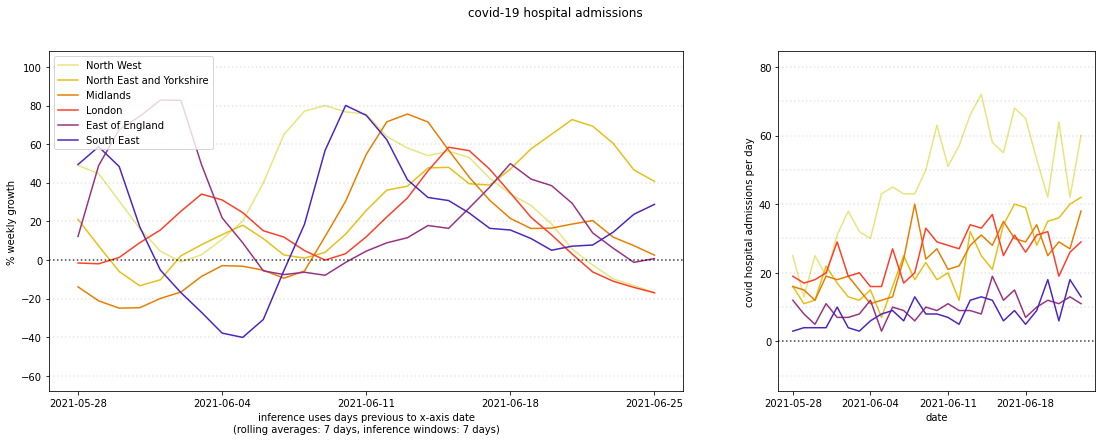

<Figure size 432x288 with 0 Axes>

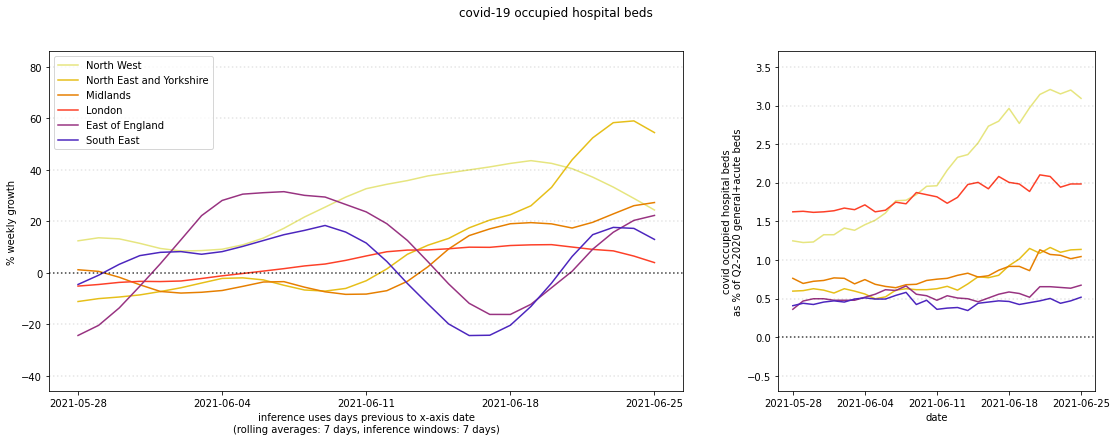

In [16]:
# HOSPITAL STUFF - plot_rates_over_time

nhsRegionOrder = ['North West', 'North East and Yorkshire', 'Midlands', 'London', 'East of England', 'South East',]# 'South West']
gen_acute_beds = {
    "London" : 14417,
    "South West" : 9261,
    "South East" : 12765,
    "Midlands" : 18113,
    "East of England" : 10255,
    "North West" : 13872,
    "North East and Yorkshire" : 16104,
}

sns.set_palette("CMRmap_r",len(gen_acute_beds))
x_dates = sorted(list(set(hosp_df.date.to_list())))

n_prev_days = 1 + 7*4
n_avg_window = 7
n_inf_window = 7

## admissions
title = "covid-19 hospital admissions"
ylabel = "covid hospital admissions per day"#,\nas % of Q2-2020 gen+acute beds"
divider_offset = 7

y_dict = {}
for nhsRegion in nhsRegionOrder:
    y_dict[nhsRegion] = np.array(hosp_df[hosp_df.areaName==nhsRegion].newAdmissions.to_list())
    #y_dict[nhsRegion] /= gen_acute_beds[nhsRegion] 
    #y_dict[nhsRegion] *= 100

plot_rates_over_time(title, x_dates, y_dict, ylabel, dividers, divider_offset, n_avg_window, n_inf_window, n_prev_days)

## occupancy
title = "covid-19 occupied hospital beds"
ylabel = "covid occupied hospital beds\nas % of Q2-2020 general+acute beds"
divider_offset = 14

y_dict = {}
for nhsRegion in nhsRegionOrder:
    y_dict[nhsRegion] = np.array(hosp_df[hosp_df.areaName==nhsRegion].hospitalCases.to_list())
    y_dict[nhsRegion] /= gen_acute_beds[nhsRegion] 
    y_dict[nhsRegion] *= 100

plot_rates_over_time(title, x_dates, y_dict, ylabel, dividers, divider_offset, n_avg_window, n_inf_window, n_prev_days)




In [8]:
# POSITIVE TESTS - fetch

api_params = {
    "areaType":"region",
    "format":"json",
}

metrics = [
    "cumCasesBySpecimenDate",
    "cumCasesBySpecimenDateRate",
    "newCasesBySpecimenDate",
]

params = ""
for k,v in api_params.items():
    params += k + "=" + v + "&"
for v in metrics:
    params += "metric=" + v + "&"

response = get("https://api.coronavirus.data.gov.uk/v2/data?" + params, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

tests_df = pd.DataFrame(response['body'])
tests_df['dateTime'] = pd.to_datetime(tests_df['date'])
tests_df.sort_values(by=['dateTime'], inplace=True)
testRegions = sorted(list(tests_df.areaName.unique()))
print(testRegions) 

['East Midlands', 'East of England', 'London', 'North East', 'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']


In [9]:
def pop(row):
    return 1e5 * row.cumCasesBySpecimenDate / row.cumCasesBySpecimenDateRate if row.cumCasesBySpecimenDateRate else -1
tests_df['pop'] = tests_df.apply(lambda row: pop(row), axis=1)

testRegionPop = {}
for region in testRegions: 
    l = tests_df[tests_df.areaName==region]['pop'].to_list()[-1:][0]
    #print(region, int(l))
    testRegionPop[region] = int(l)


<Figure size 432x288 with 0 Axes>

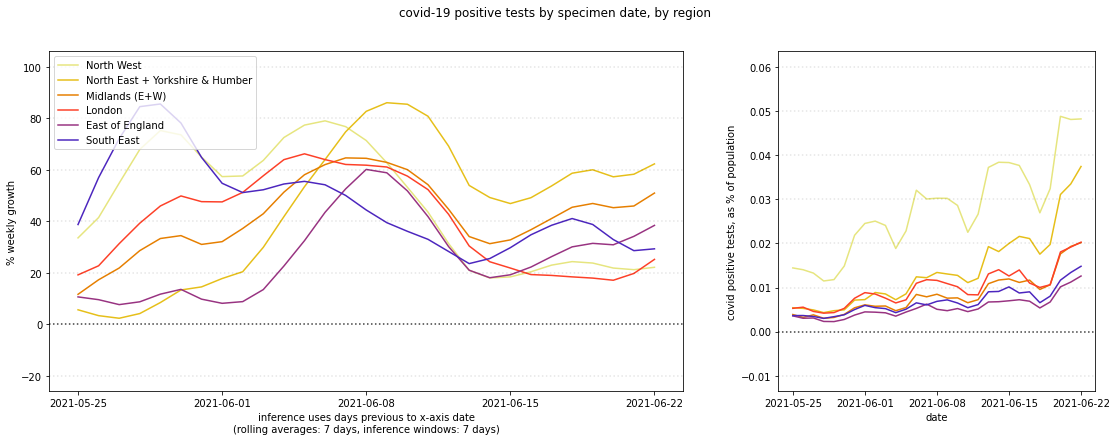

In [10]:
testRegionOrder = ['North West', 'North East + Yorkshire & Humber', 'Midlands (E+W)', 'London', 'East of England', 'South East',]# 'South West']
popn = {
    "Midlands (E+W)" : 4835902 + 5934009,
    "East of England" : 6236116,
    "London" : 8962001,
    "North East + Yorkshire & Humber" : 2669924 + 5502918,
    "North West" : 7341204,
    "South East" : 9180140,
    "South West" : 5624775,
}

sns.set_palette("CMRmap_r",len(popn))

n_prev_days = 1 + 7*4
n_avg_window = 7
n_inf_window = 7
n_clip_recent = 2

x_dates = sorted(list(set(tests_df.date.to_list())))
x_dates = x_dates[:len(x_dates)-n_clip_recent-1]

title = "covid-19 positive tests by specimen date, by region"
ylabel = "covid positive tests, as % of population"
divider_offset = 7

_y_dict = {}
for region in testRegions:
    _y_dict[region] = np.array(tests_df[tests_df.areaName==region].newCasesBySpecimenDate.to_list())   

y_dict = {}
for region in testRegions:
    _y_dict[region] = _y_dict[region][:-n_clip_recent]
_y_dict['Midlands (E+W)'] = _y_dict['East Midlands'][-150:] + _y_dict['West Midlands'][-150:] # diff lengths, hack
_y_dict['North East + Yorkshire & Humber'] = _y_dict['North East'][-150:] + _y_dict['Yorkshire and The Humber'][-150:] # diff lengths, hack

for region in testRegionOrder:
    y_dict[region] = _y_dict[region] / popn[region] * 100
    
plot_rates_over_time(title, x_dates, y_dict, ylabel, dividers, divider_offset, n_avg_window, n_inf_window, n_prev_days)


In [11]:
# POSITIVE TESTS AGE DEMOGRAPHICS - fetch
#url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newCasesBySpecimenDateAgeDemographics&format=json"
male_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=maleCases&format=json"
response = get(male_url, timeout=30)
print(response)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }\nStatus Code: {response.status_code}')
response = response.json()
age_tests_df_male = pd.DataFrame(response['body'])

female_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=femaleCases&format=json"
response = get(female_url, timeout=30)
print(response)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }\nStatus Code: {response.status_code}')
response = response.json()
age_tests_df_female = pd.DataFrame(response['body'])


age_tests_df_male['dateTime'] = pd.to_datetime(age_tests_df_male['date'])
age_tests_df_male.sort_values(by=['dateTime'], inplace=True)
age_tests_df_female['dateTime'] = pd.to_datetime(age_tests_df_female['date'])
age_tests_df_female.sort_values(by=['dateTime'], inplace=True)
ageTestRegions = sorted(list(age_tests_df_male.areaName.unique()))
print(ageTestRegions)     

<Response [200]>
<Response [200]>
['England']


<Figure size 432x288 with 0 Axes>

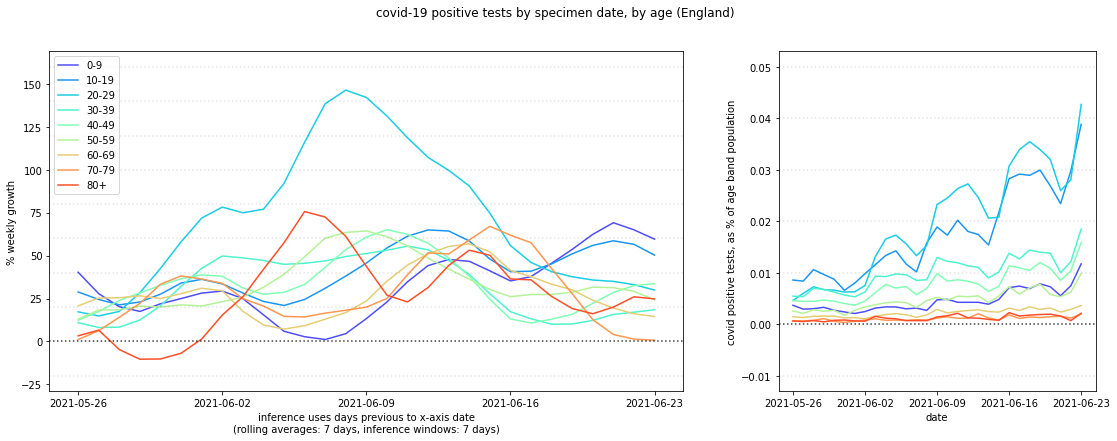

In [12]:
ageBands = {
    "0-9":['0_to_4','5_to_9'],
    "10-19":['10_to_14','15_to_19'], 
    "20-29":['20_to_24','25_to_29'],
    "30-39":['30_to_34','35_to_39'],
    "40-49":['40_to_44','45_to_49'], 
    "50-59":['50_to_54','55_to_59'], 
    "60-69":['60_to_64','65_to_69'],
    "70-79":['70_to_74','75_to_79'],
    "80+":['80_to_84','85_to_89','90+'],
    #"90+":['90+']
}
popn = { # millions
    "0-9":3.86+4.15,
    "10-19":3.95+3.66, 
    "20-29":4.15+4.51,
    "30-39":4.5+4.4,
    "40-49":4.02+4.4, 
    "50-59":4.66+4.41, 
    "60-69":3.76+3.37,
    "70-79":3.32+2.33,
    "80+":1.72+1.04+0.61,
    #"90+":,
}

sns.set_palette("rainbow",len(ageBands.keys()))

n_prev_days = 1 + 7*4
n_avg_window = 7
n_inf_window = 7
n_clip_recent = 2

x_dates = sorted(list(set(age_tests_df_male.date.to_list())))
x_dates = x_dates[:len(x_dates)-n_clip_recent] 

title = "covid-19 positive tests by specimen date, by age (England)"
ylabel = "covid positive tests, as % of age band population"
divider_offset = 7

y_dict = {}
list_of_dicts_male = age_tests_df_male.maleCases.to_list()[:len(x_dates)-n_clip_recent] 
list_of_dicts_female = age_tests_df_female.femaleCases.to_list()[:len(x_dates)-n_clip_recent] 

def process_list_of_dicts(list_of_dicts):
    for ageBand, rawAgeBands in ageBands.items():
        y_dict[ageBand] = []
        for item in list_of_dicts: # unpack the json...
            if len(item)==0:
                y_dict[ageBand].append(np.nan)
                continue
            v = 0
            for l in item:
                if l["age"] in rawAgeBands:
                    v += l["value"]
            v /= popn[ageBand]*1e6
            v *= 100
            y_dict[ageBand].append(v)  
        assert(y_dict[ageBand][-1] is not np.nan)
    return y_dict

y_dict_male = process_list_of_dicts(list_of_dicts_male)
y_dict_female = process_list_of_dicts(list_of_dicts_female)
for ageBand in ageBands.keys():
    y_dict[ageBand] = np.array(y_dict_male[ageBand]) + np.array(y_dict_female[ageBand])
    y_dict[ageBand] = np.diff(y_dict[ageBand])

#print(y_dict)

#del y_dict["90+"]
    
plot_rates_over_time(title, x_dates, y_dict, ylabel, dividers, divider_offset, n_avg_window, n_inf_window, n_prev_days)



In [13]:
# HOSPITAL ADMISSIONS AGE DEMOGRAPHICS - fetch
url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=cumAdmissionsByAge&format=json"
response = get(url, timeout=30)
print(response)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }\nStatus Code: {response.status_code}')
response = response.json()

age_admiss_df = pd.DataFrame(response['body'])
age_admiss_df['dateTime'] = pd.to_datetime(age_admiss_df['date'])
age_admiss_df.sort_values(by=['dateTime'], inplace=True)
ageAdmissRegions = sorted(list(age_admiss_df.areaName.unique()))
print(ageAdmissRegions) 


<Response [200]>
['England']


<Figure size 432x288 with 0 Axes>

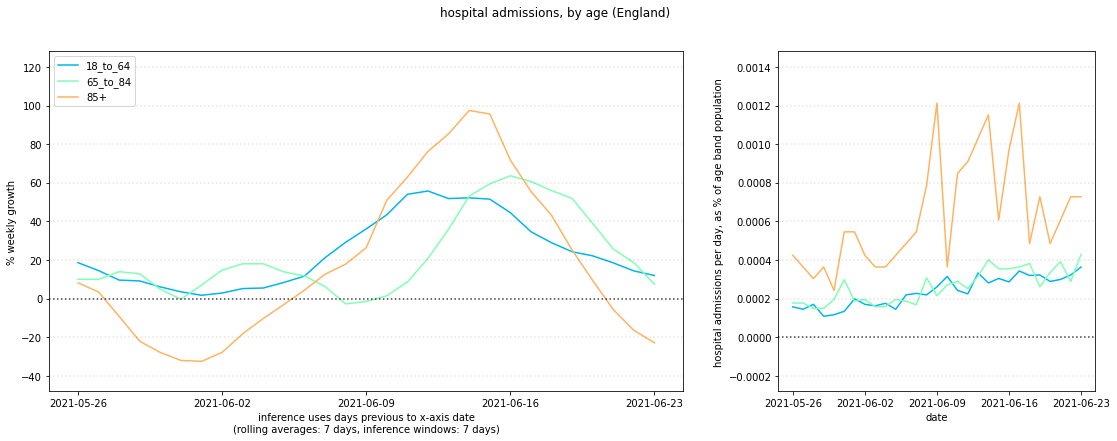

In [14]:
popn = { # millions
    #"0_to_5":1,
    #"6_to_17":1,
    "18_to_64":4.15+4.51+4.5+4.4+4.02+4.4+4.66+4.41+3.76,
    "65_to_84":3.37+3.32+2.33+1.72,
    "85+":1.04+0.61,
}

sns.set_palette("rainbow",len(popn.keys()))

n_prev_days = 1 + 7*4
n_avg_window = 7
n_inf_window = 7

x_dates = sorted(list(set(age_admiss_df.date.to_list())))
x_dates = x_dates

title = "hospital admissions, by age (England)"
ylabel = "hospital admissions per day, as % of age band population"
divider_offset = 7

y_dict = {}
list_of_dicts = age_admiss_df.cumAdmissionsByAge.to_list()
for ageBand in popn.keys():
    y_dict[ageBand] = []
    for item in list_of_dicts: # unpack the json...
        if len(item)==0:
            y_dict[ageBand].append(np.nan)
            continue
        v = 0
        for l in item:
            if l["age"]==ageBand:
                v += l["value"]
        v /= popn[ageBand]*1e6
        v *= 100
        y_dict[ageBand].append(v)  

for ageBand in y_dict.keys():
    y_dict[ageBand] = np.diff(y_dict[ageBand])
        
plot_rates_over_time(title, x_dates, y_dict, ylabel, dividers, divider_offset, n_avg_window, n_inf_window, n_prev_days)

